In [1]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()

In [5]:
from azureml.core.model import InferenceConfig

run =ws.get_run('AutoML_398dd406-947e-423a-8958-6841ab4956bb')
best_child_run = run.get_best_child()

best_child_run.download_file(
    "outputs/scoring_file_v_1_0_0.py", output_file_path="score.py"
)
environment = best_child_run.get_environment()
print(environment.python.conda_dependencies.serialize_to_string())

inference_config = InferenceConfig(entry_script="score.py", environment=environment)

channels:
- conda-forge
dependencies:
- python=3.7
- pip=21.3.1
- numpy==1.18.5
- libffi=3.3
- pip:
  - azureml-core==1.40.0
  - azureml-mlflow==1.40.0
  - azureml-dataset-runtime==1.40.0
  - azureml-telemetry==1.40.0
  - azureml-responsibleai==1.40.0
  - azureml-automl-core==1.40.0
  - azureml-automl-runtime==1.40.0
  - azureml-train-automl-client==1.40.0
  - azureml-defaults==1.40.0
  - azureml-interpret==1.40.0
  - azureml-train-automl-runtime==1.40.0.post1
  - azureml-automl-dnn-vision==1.40.0
  - azureml-dataprep>=2.24.4
name: azureml_f294a5829316d8d572d971fc2fa2ee48



In [7]:
# Deploy the model as a web service
from azureml.core.model import Model
from azureml.core.webservice import AciWebservice

model = ws.models['AutoML398dd40692']

deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=8)

service = Model.deploy(
    ws,
    models=[model],
    inference_config=inference_config,
    deployment_config=deployment_config,
    name="xray",
    overwrite=True,
)
service.wait_for_deployment(show_output=True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-04-17 15:53:15+00:00 Creating Container Registry if not exists.
2022-04-17 15:53:15+00:00 Registering the environment.
2022-04-17 15:53:17+00:00 Use the existing image.
2022-04-17 15:53:17+00:00 Generating deployment configuration.
2022-04-17 15:53:18+00:00 Submitting deployment to compute.
2022-04-17 15:53:23+00:00 Checking the status of deployment xray..
2022-04-17 16:04:57+00:00 Checking the status of inference endpoint xray.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [13]:
import requests

# URL for the web service
scoring_uri = service.scoring_uri

sample_image = "./Xray/test_c.jpeg"

# Load image data
data = open(sample_image, "rb").read()

# Set the content type
headers = {"Content-Type": "application/octet-stream"}

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print(resp.text)

{"filename": "/tmp/tmp2janjr86", "probs": [0.6836777329444885, 0.31564849615097046, 0.0006738569936715066], "labels": ["Covid", "Normal", "Pneumonia"]}



Covid (0.684)


<Figure size 1296x864 with 0 Axes>

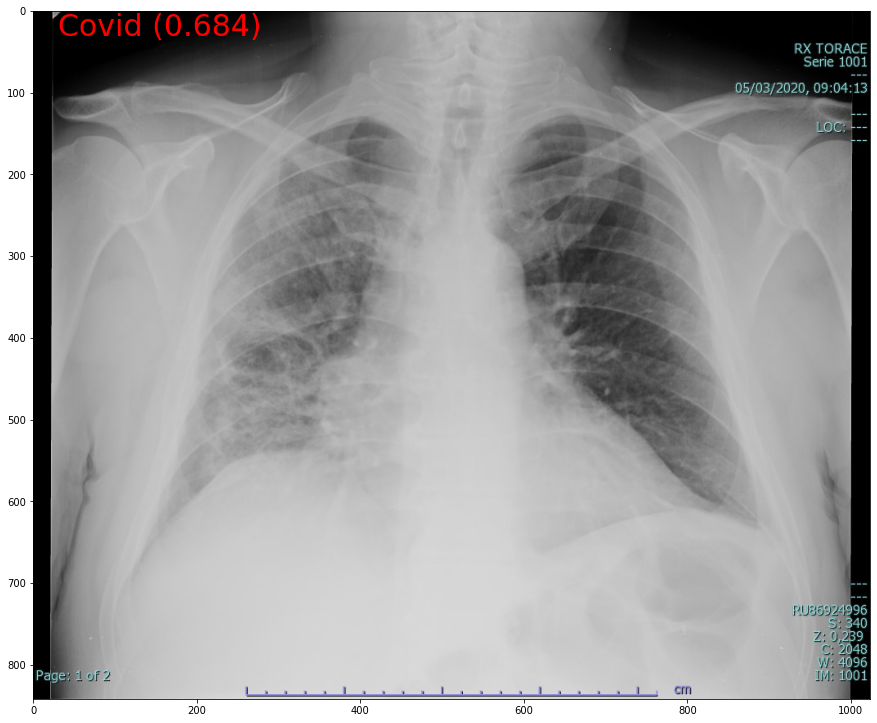

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

prediction = json.loads(resp.text)
label_index = np.argmax(prediction["probs"])
label = prediction["labels"][label_index]
conf_score = prediction["probs"][label_index]

display_text = "{} ({})".format(label, round(conf_score, 3))
print(display_text)

color = "red"
plt.text(30, 30, display_text, color=color, fontsize=30)

plt.show()

In [ ]:
service.delete()
print ('Service deleted.')

In [18]:
!pip install torchinfo

In [19]:
from torchinfo import summary

model_summary = summary(model, input_size=(1,1, 224, 224))
print(str(model_summary))

ModuleNotFoundError: No module named 'torchinfo'